<h1> Gradient Boosting

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
data = pd.read_csv('data/training_c.csv')
data

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25.0,130,80.0,72.0,98,86.0,high risk
1,35.0,140,90.0,72.0,98,70.0,high risk
2,29.0,90,70.0,72.0,100,80.0,high risk
3,30.0,140,85.0,72.0,98,70.0,high risk
4,35.0,120,60.0,61.0,98,76.0,low risk
...,...,...,...,...,...,...,...
1004,48.0,120,80.0,72.0,98,88.0,high risk
1005,22.0,120,60.0,72.0,98,80.0,high risk
1006,55.0,120,90.0,72.0,98,60.0,high risk
1007,35.0,85,60.0,72.0,98,86.0,high risk


In [12]:
# Divisione in training e test
X = data.drop("RiskLevel", axis=1)  # Separa le colonne contenenti le feature (escludendo "RiskLevel")
y = data['RiskLevel']  # Estrai la colonna target ("RiskLevel")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Con il RandomizedSearch per trovare i migliori parametri da utilizzare nel gradient boosting

In [13]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Definizione di parametri con range ampi
param_distributions = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4]
}
model = GradientBoostingClassifier(random_state=42)

# Randomized Search
random_search = RandomizedSearchCV(
    model, param_distributions, n_iter=50, cv=3, scoring='accuracy', n_jobs=-1, random_state=42, verbose=1
)

# Addestramento con ricerca casuale
random_search.fit(X_train, y_train)

# Migliori parametri trovati
print("Migliori parametri:", random_search.best_params_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Migliori parametri: {'subsample': 1.0, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 6, 'learning_rate': 0.3}


Implementiamo il modello Gradient Boosting con scikit learn

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

# Recupera i migliori parametri trovati
best_params = random_search.best_params_

# Crea un nuovo modello Gradient Boosting con i migliori parametri
final_model = GradientBoostingClassifier(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    subsample=best_params['subsample'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
    
)

# Addestra il modello sull'intero training set
final_model.fit(X_train, y_train)

# Predizioni sul test set
y_pred = final_model.predict(X_test)

# Valutazione del modello
print(f"Accuratezza sul test set: {accuracy_score(y_test, y_pred):.2f}")
print("\nReport di classificazione:")
print(classification_report(y_test, y_pred))


Accuratezza sul test set: 0.86

Report di classificazione:
              precision    recall  f1-score   support

   high risk       0.91      0.89      0.90        54
    low risk       0.86      0.88      0.87        81
    mid risk       0.82      0.81      0.81        67

    accuracy                           0.86       202
   macro avg       0.86      0.86      0.86       202
weighted avg       0.86      0.86      0.86       202



       Feature  Importance
1   SystolicBP    0.332515
3           BS    0.243029
0          Age    0.170263
5    HeartRate    0.085508
2  DiastolicBP    0.085322
4     BodyTemp    0.083365


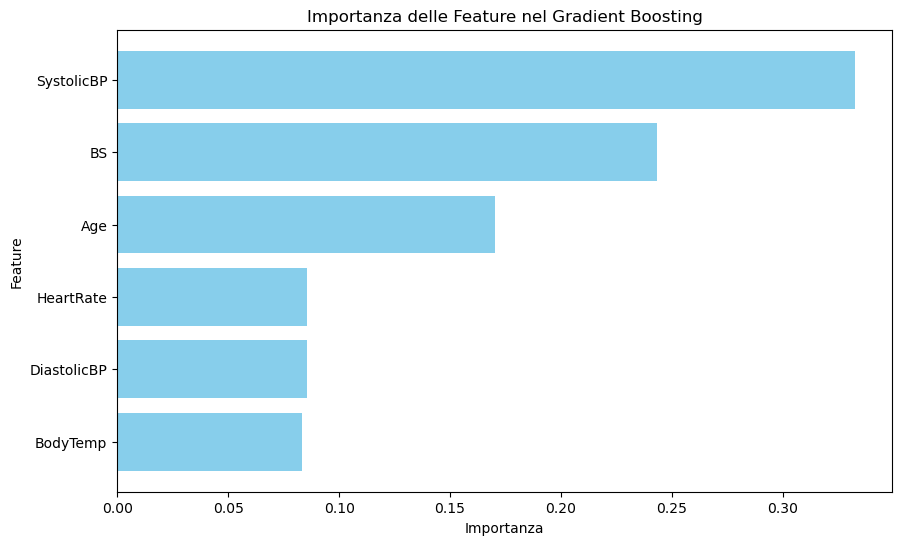

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Ottieni l'importanza delle feature
feature_importances = final_model.feature_importances_

# Crea un DataFrame per organizzare i dati
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Stampa l'importanza delle feature
print(importance_df)

# Visualizza un grafico a barre delle feature
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Inverti l'asse y per vedere la feature più importante in alto
plt.xlabel('Importanza')
plt.ylabel('Feature')
plt.title('Importanza delle Feature nel Gradient Boosting')
plt.show()


In [16]:
from sklearn.model_selection import cross_val_score

# Calcola la cross-validation con il modello finale
scores = cross_val_score(final_model, X, y, cv=5, scoring='accuracy')
print(f"Accuratezza media con cross-validation: {scores.mean():.2f}")

Accuratezza media con cross-validation: 0.81


Matrice di confusione

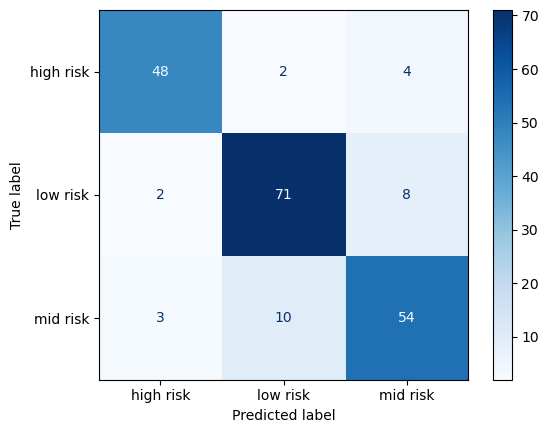

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Creazione della matrice di confusione
cm = confusion_matrix(y_test, y_pred, labels=final_model.classes_)

# Visualizzazione
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
disp.plot(cmap="Blues")


Visualizziamo alcune curve utili per comprendere le prestazioni del modello e come si comporta con il dataset

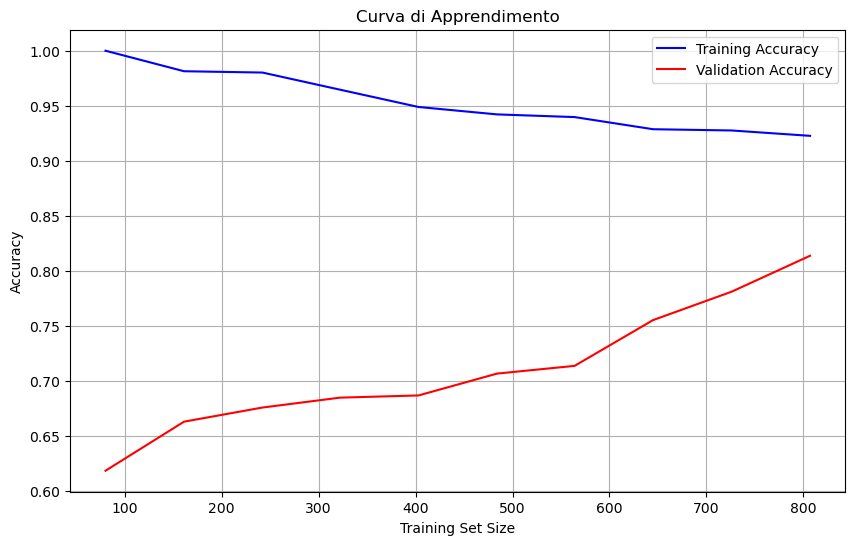

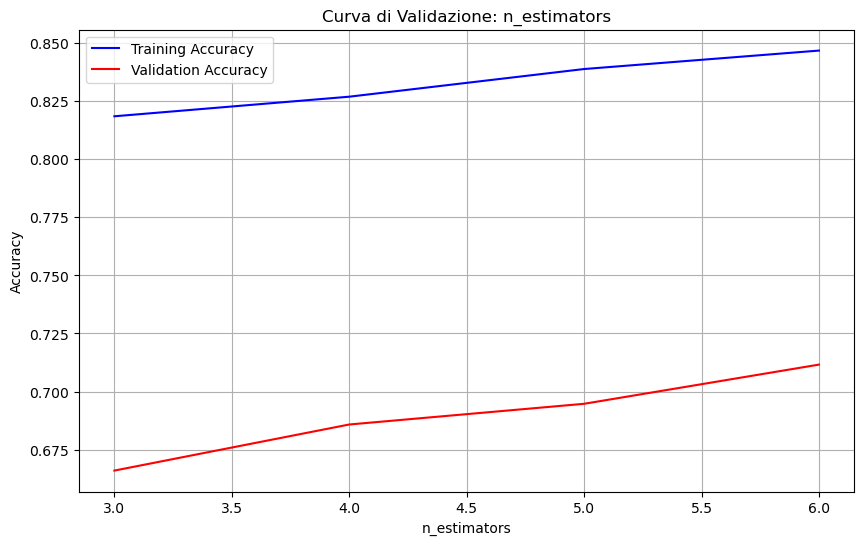

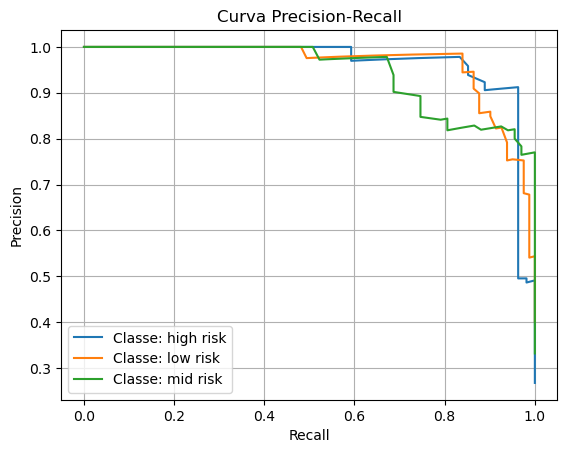

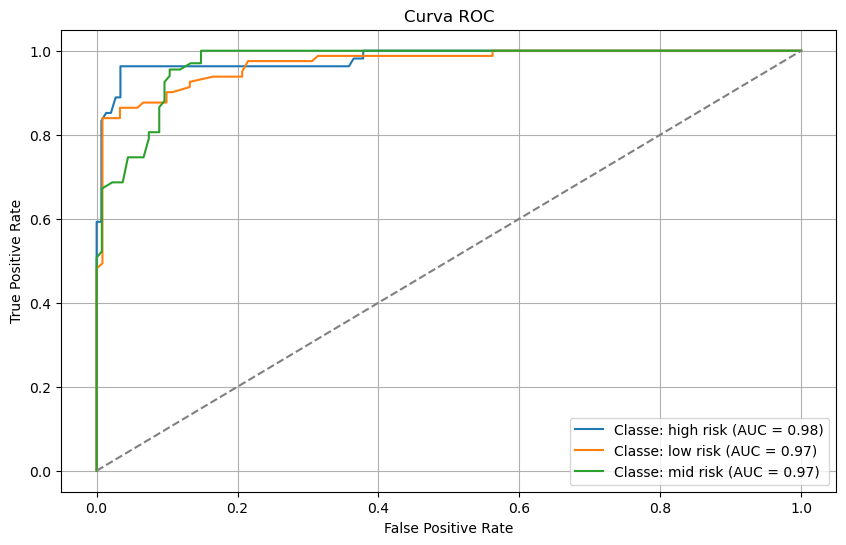

In [18]:

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score
from sklearn.model_selection import learning_curve, validation_curve

# --- 1. CURVA DI APPRENDIMENTO ---
def plot_learning_curve(model, X, y, cv=5):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training Accuracy', color='blue')
    plt.plot(train_sizes, val_mean, label='Validation Accuracy', color='red')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.title('Curva di Apprendimento')
    plt.legend()
    plt.grid()
    plt.show()

# --- 2. CURVA DI VALIDAZIONE ---
def plot_validation_curve(model, X, y, param_name, param_range, cv=5):
    train_scores, val_scores = validation_curve(
        model, X, y, param_name=param_name, param_range=param_range, cv=cv, scoring='accuracy', n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(param_range, train_mean, label='Training Accuracy', color='blue')
    plt.plot(param_range, val_mean, label='Validation Accuracy', color='red')
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.title(f'Curva di Validazione: {param_name}')
    plt.legend()
    plt.grid()
    plt.show()

# --- 3. CURVA PRECISION-RECALL ---
def plot_precision_recall_curve(model, X_test, y_test):
    y_prob = model.predict_proba(X_test)
    for i, class_label in enumerate(model.classes_):
        precision, recall, _ = precision_recall_curve(y_test == class_label, y_prob[:, i])
        plt.plot(recall, precision, label=f'Classe: {class_label}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Curva Precision-Recall')
    plt.legend()
    plt.grid()
    plt.show()

# --- 4. CURVA ROC-AUC (OPZIONALE) ---
def plot_roc_curve(model, X_test, y_test):
    y_prob = model.predict_proba(X_test)
    plt.figure(figsize=(10, 6))

    for i, class_label in enumerate(model.classes_):
        fpr, tpr, _ = roc_curve(y_test == class_label, y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Classe: {class_label} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend()
    plt.grid()
    plt.show()

# Esecuzione dei grafici
# Gradient Boosting model già ottimizzato
plot_learning_curve(final_model, X, y)

# Curva di validazione per un iperparametro, es. 'max_depth'
plot_validation_curve(final_model, X, y, param_name='n_estimators', param_range=[3, 4, 5, 6])

# Precision-Recall
plot_precision_recall_curve(final_model, X_test, y_test)

# ROC-AUC (opzionale)
plot_roc_curve(final_model, X_test, y_test)
